
**Konu:** YOLOv8 ile Nesne Tespiti ve Görme Engelliler İçin Para Tanıma Sistemi
**Hazırlayan:** İsmail AYKURT -
**Okul Numarası: 2212721061**
Gitgub Link:
## 🎯 Projenin Amacı
Bu çalışmanın amacı, görme engelli bireylerin günlük hayatta kağıt ve bozuk paraları ayırt etmelerine yardımcı olacak bir yapay zeka modeli geliştirmektir. Proje kapsamında kendi oluşturduğum özgün veri seti kullanılmış ve **YOLOv8 (You Only Look Once)** algoritması ile model eğitimi gerçekleştirilmiştir. Elde edilen model, PyQt5 tabanlı bir masaüstü arayüzüne entegre edilerek sesli geri bildirim sağlayan bir asistan haline getirilmiştir.

# 1. Çalışma Ortamının Hazırlanması ve Veri Seti Entegrasyonu

Bu bölümde, projenin temelini oluşturan **YOLOv8** mimarisini kullanabilmek için gerekli `ultralytics` kütüphanesi kurulmakta ve donanım kontrolü yapılmaktadır. Eğitim süresini optimize etmek adına **GPU (CUDA)** desteğinin aktif olup olmadığı `checks()` fonksiyonu ile doğrulanır.

Ardından, proje için özel olarak hazırlanan ve etiketlenen veri seti **Roboflow API** aracılığıyla çalışma ortamına dahil edilir. Veri seti indirilirken modelin beklediği **YOLOv8 formatı** (klasör yapısı ve .yaml dosyası) otomatik olarak yapılandırılır.

In [4]:
# ==========================================
# A) Gerekli Kütüphanelerin Kurulumu
# ==========================================

# YOLOv8 modelini içeren ve nesne tespiti için gerekli araçları sunan kütüphaneyi kuruyoruz.
!pip install ultralytics

# Kurulum sırasında oluşan uzun log çıktılarını temizleyerek notebook'un daha okunabilir olmasını sağlıyoruz.
from IPython import display
display.clear_output()

import ultralytics
# Sistemin donanım özelliklerini kontrol ediyoruz.
# Burada amaç, Google Colab'in sunduğu GPU (Tesla T4 vb.) desteğinin aktif olduğunu teyit etmektir.
ultralytics.checks()

# ==========================================
# B) Veri Setinin İndirilmesi (Roboflow)
# ==========================================

# Veri setini API üzerinden çekmek için Roboflow kütüphanesini yüklüyoruz.
!pip install roboflow

from roboflow import Roboflow

# Roboflow platformuna API anahtarı ile yetkilendirme yaparak bağlanıyoruz.
rf = Roboflow(api_key="NhELt0SohvOjdwRZKla3")

# 'bitktespit' çalışma alanındaki 'para_tespiti_yolo' projesine erişiyoruz.
project = rf.workspace("bitktespit").project("para_tespiti_yolo")

# Veri setinin "Augmentation" (Veri artırma) işlemlerinin uygulandığı 2. versiyonunu seçiyoruz.
version = project.version(2)

# Veriyi YOLOv8 modelinin eğitimine uygun formatta (train/val klasörleri ve data.yaml dosyası ile) indiriyoruz.
dataset = version.download("yolov8")

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/112.6 GB disk)
loading Roboflow workspace...
loading Roboflow project...


# 2. Model Eğitimi (Training)

Bu aşamada, **Transfer Learning (Transfer Öğrenme)** yöntemi kullanılarak model eğitimi gerçekleştirilmektedir. Sıfırdan bir ağırlık (weights) eğitmek yerine, COCO veri seti üzerinde önceden eğitilmiş olan **`yolov8n.pt` (Nano)** modeli başlangıç noktası olarak seçilmiştir. Nano model, düşük kaynak tüketimi ve yüksek çıkarım hızı (inference speed) nedeniyle tercih edilmiştir.

**Kullanılan Hiperparametreler:**
* **Epochs (50):** Modelin tüm veri seti üzerinden 50 kez geçmesi sağlanarak, öğrenme sürecinin doygunluğa ulaşması hedeflenmiştir.
* **Image Size (640):** YOLOv8'in standart giriş çözünürlüğü olan 640x640 piksel kullanılarak, küçük nesnelerin (bozuk paralar) detay kaybı olmadan tespit edilmesi amaçlanmıştır.
* **Batch Size:** Donanım kapasitesine (GPU VRAM) göre otomatik olarak optimize edilmiştir.

In [5]:
# ==========================================
# C) YOLOv8 Eğitim Sürecinin Başlatılması
# ==========================================

# YOLO CLI (Komut Satırı Arayüzü) komutu ile eğitimi başlatıyoruz.
# task=detect       -> Görevimiz: Nesne Tespiti (Object Detection)
# mode=train        -> Modumuz: Eğitim (Training)
# model=yolov8n.pt  -> Temel Model: En hızlı ve hafif sürüm olan 'Nano' modeli
# data={...}        -> Veri seti konfigürasyon dosyasının (.yaml) dinamik yolu
# epochs=50         -> İterasyon sayısı (Eğitim döngüsü)
# imgsz=640         -> Giriş görüntülerinin yeniden boyutlandırılacağı çözünürlük

!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=50 imgsz=640

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Para_Tespiti_YOLO-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

# 3. Eğitim Sonuçlarının Değerlendirilmesi (Evaluation)

Modelin başarısını ölçmek için eğitim süreci boyunca kaydedilen metrikler incelenmektedir.
* **Loss Grafikleri:** Eğitim ve doğrulama hatasının (loss) düşüş eğiliminde olması, modelin öğrenme yeteneğini gösterir.
* **mAP (Mean Average Precision):** Modelin doğruluk skorudur. Bu değerin 1.0'a yaklaşması (Örn: 0.99), modelin paraları ayırt etmede çok başarılı olduğunu kanıtlar.
* **Confusion Matrix:** Modelin hangi sınıfları karıştırdığını (Örn: 1 TL ile 50 Kuruş'u karıştırıp karıştırmadığı) analiz etmek için kullanılır.

İncelenen Eğitim Klasörü: runs/detect/train

--- Eğitim Sonuçları (Loss & Accuracy) ---


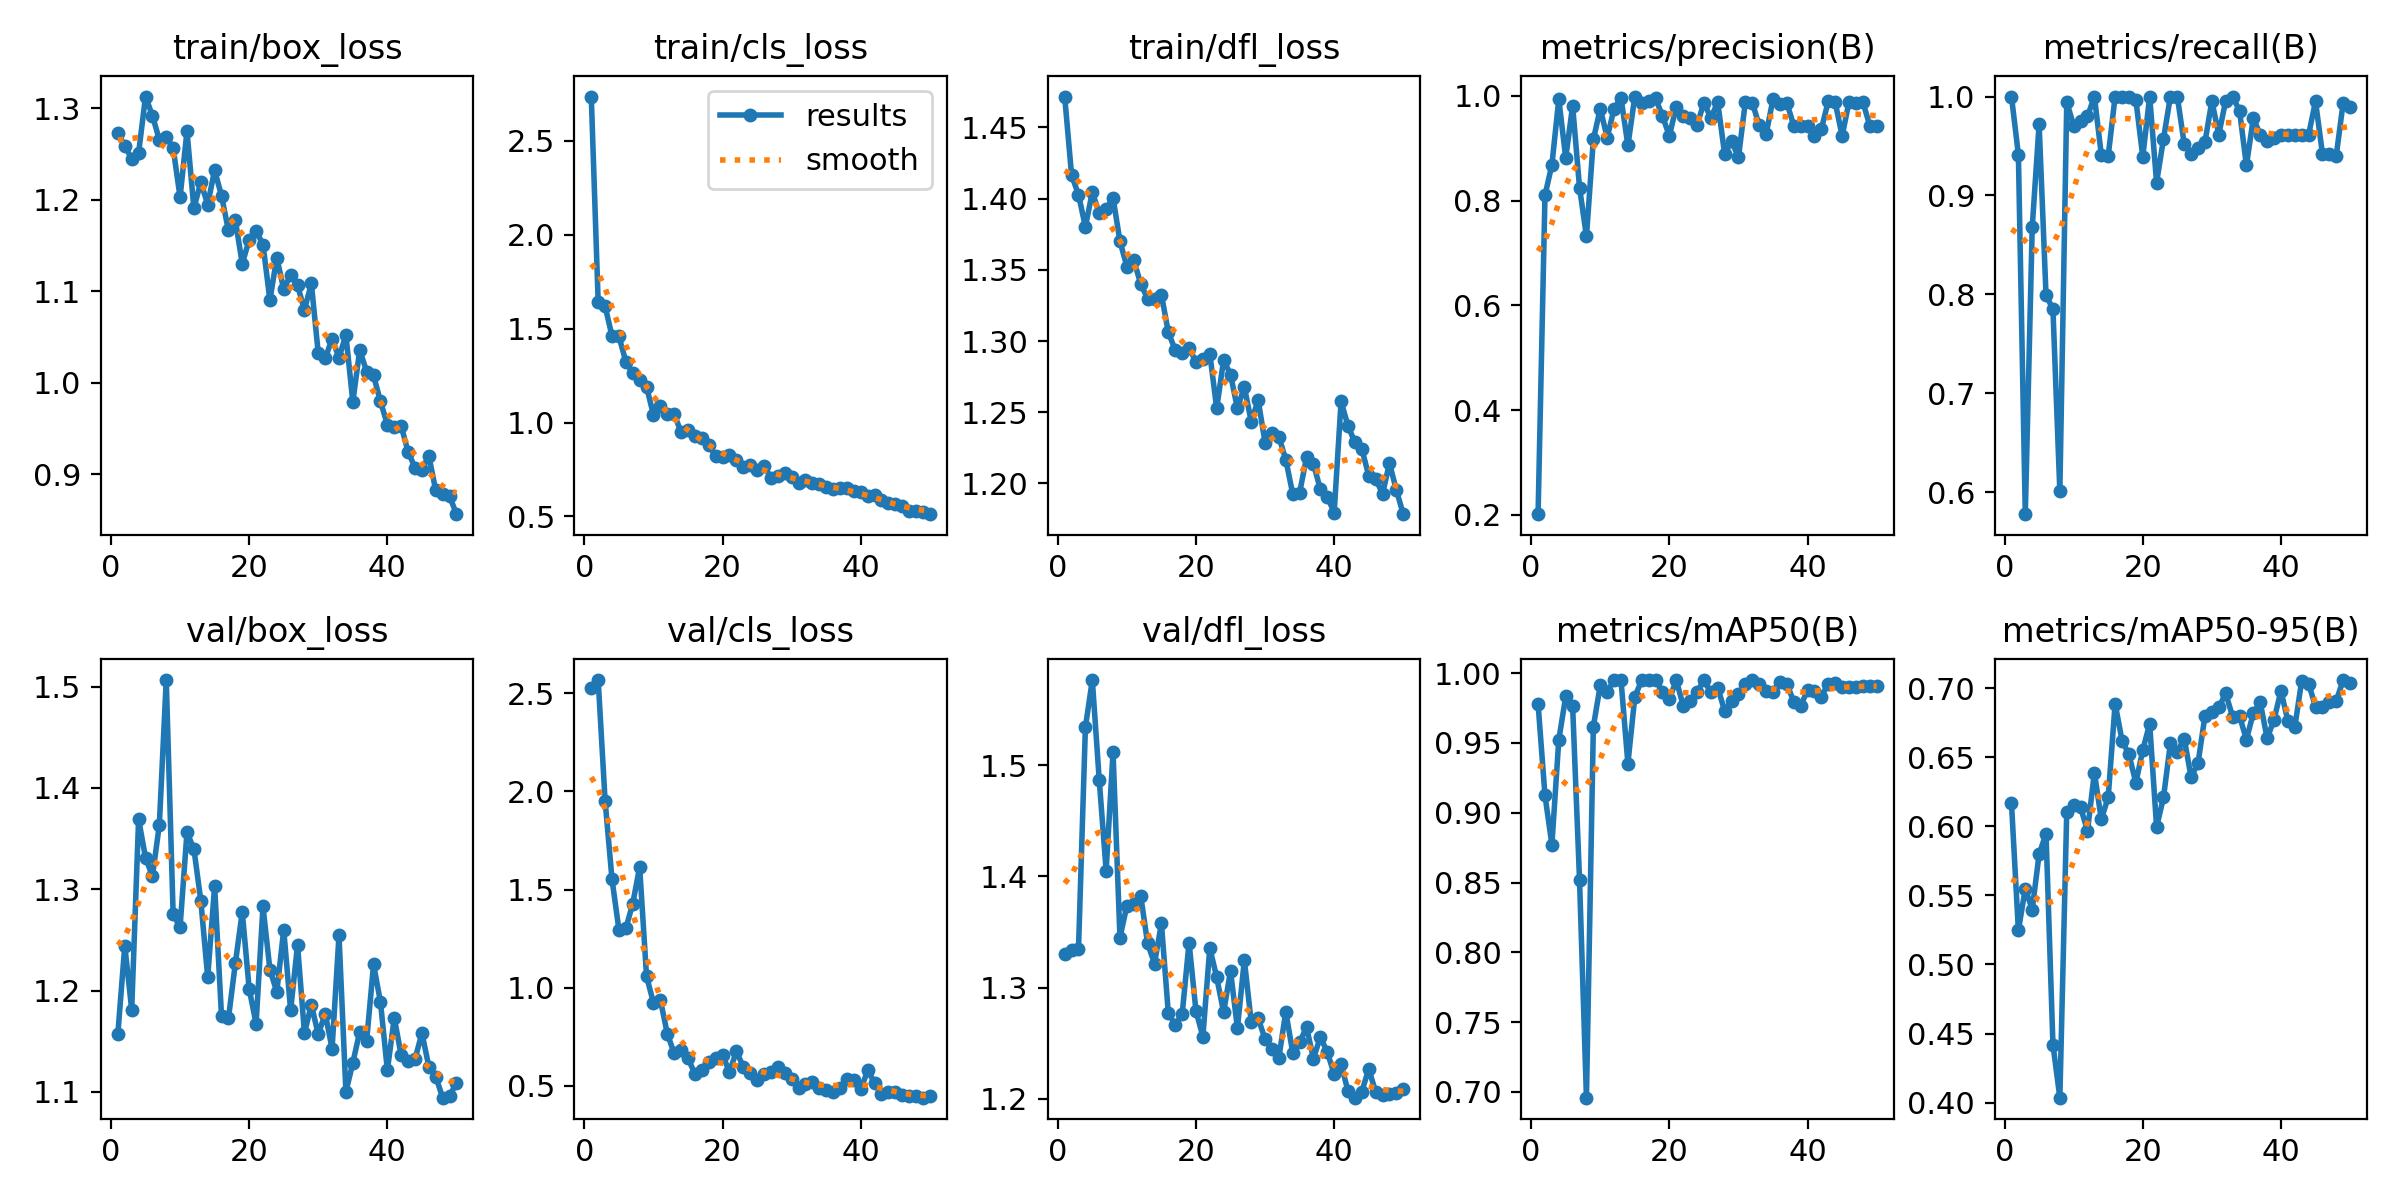


--- Karmaşıklık Matrisi (Confusion Matrix) ---


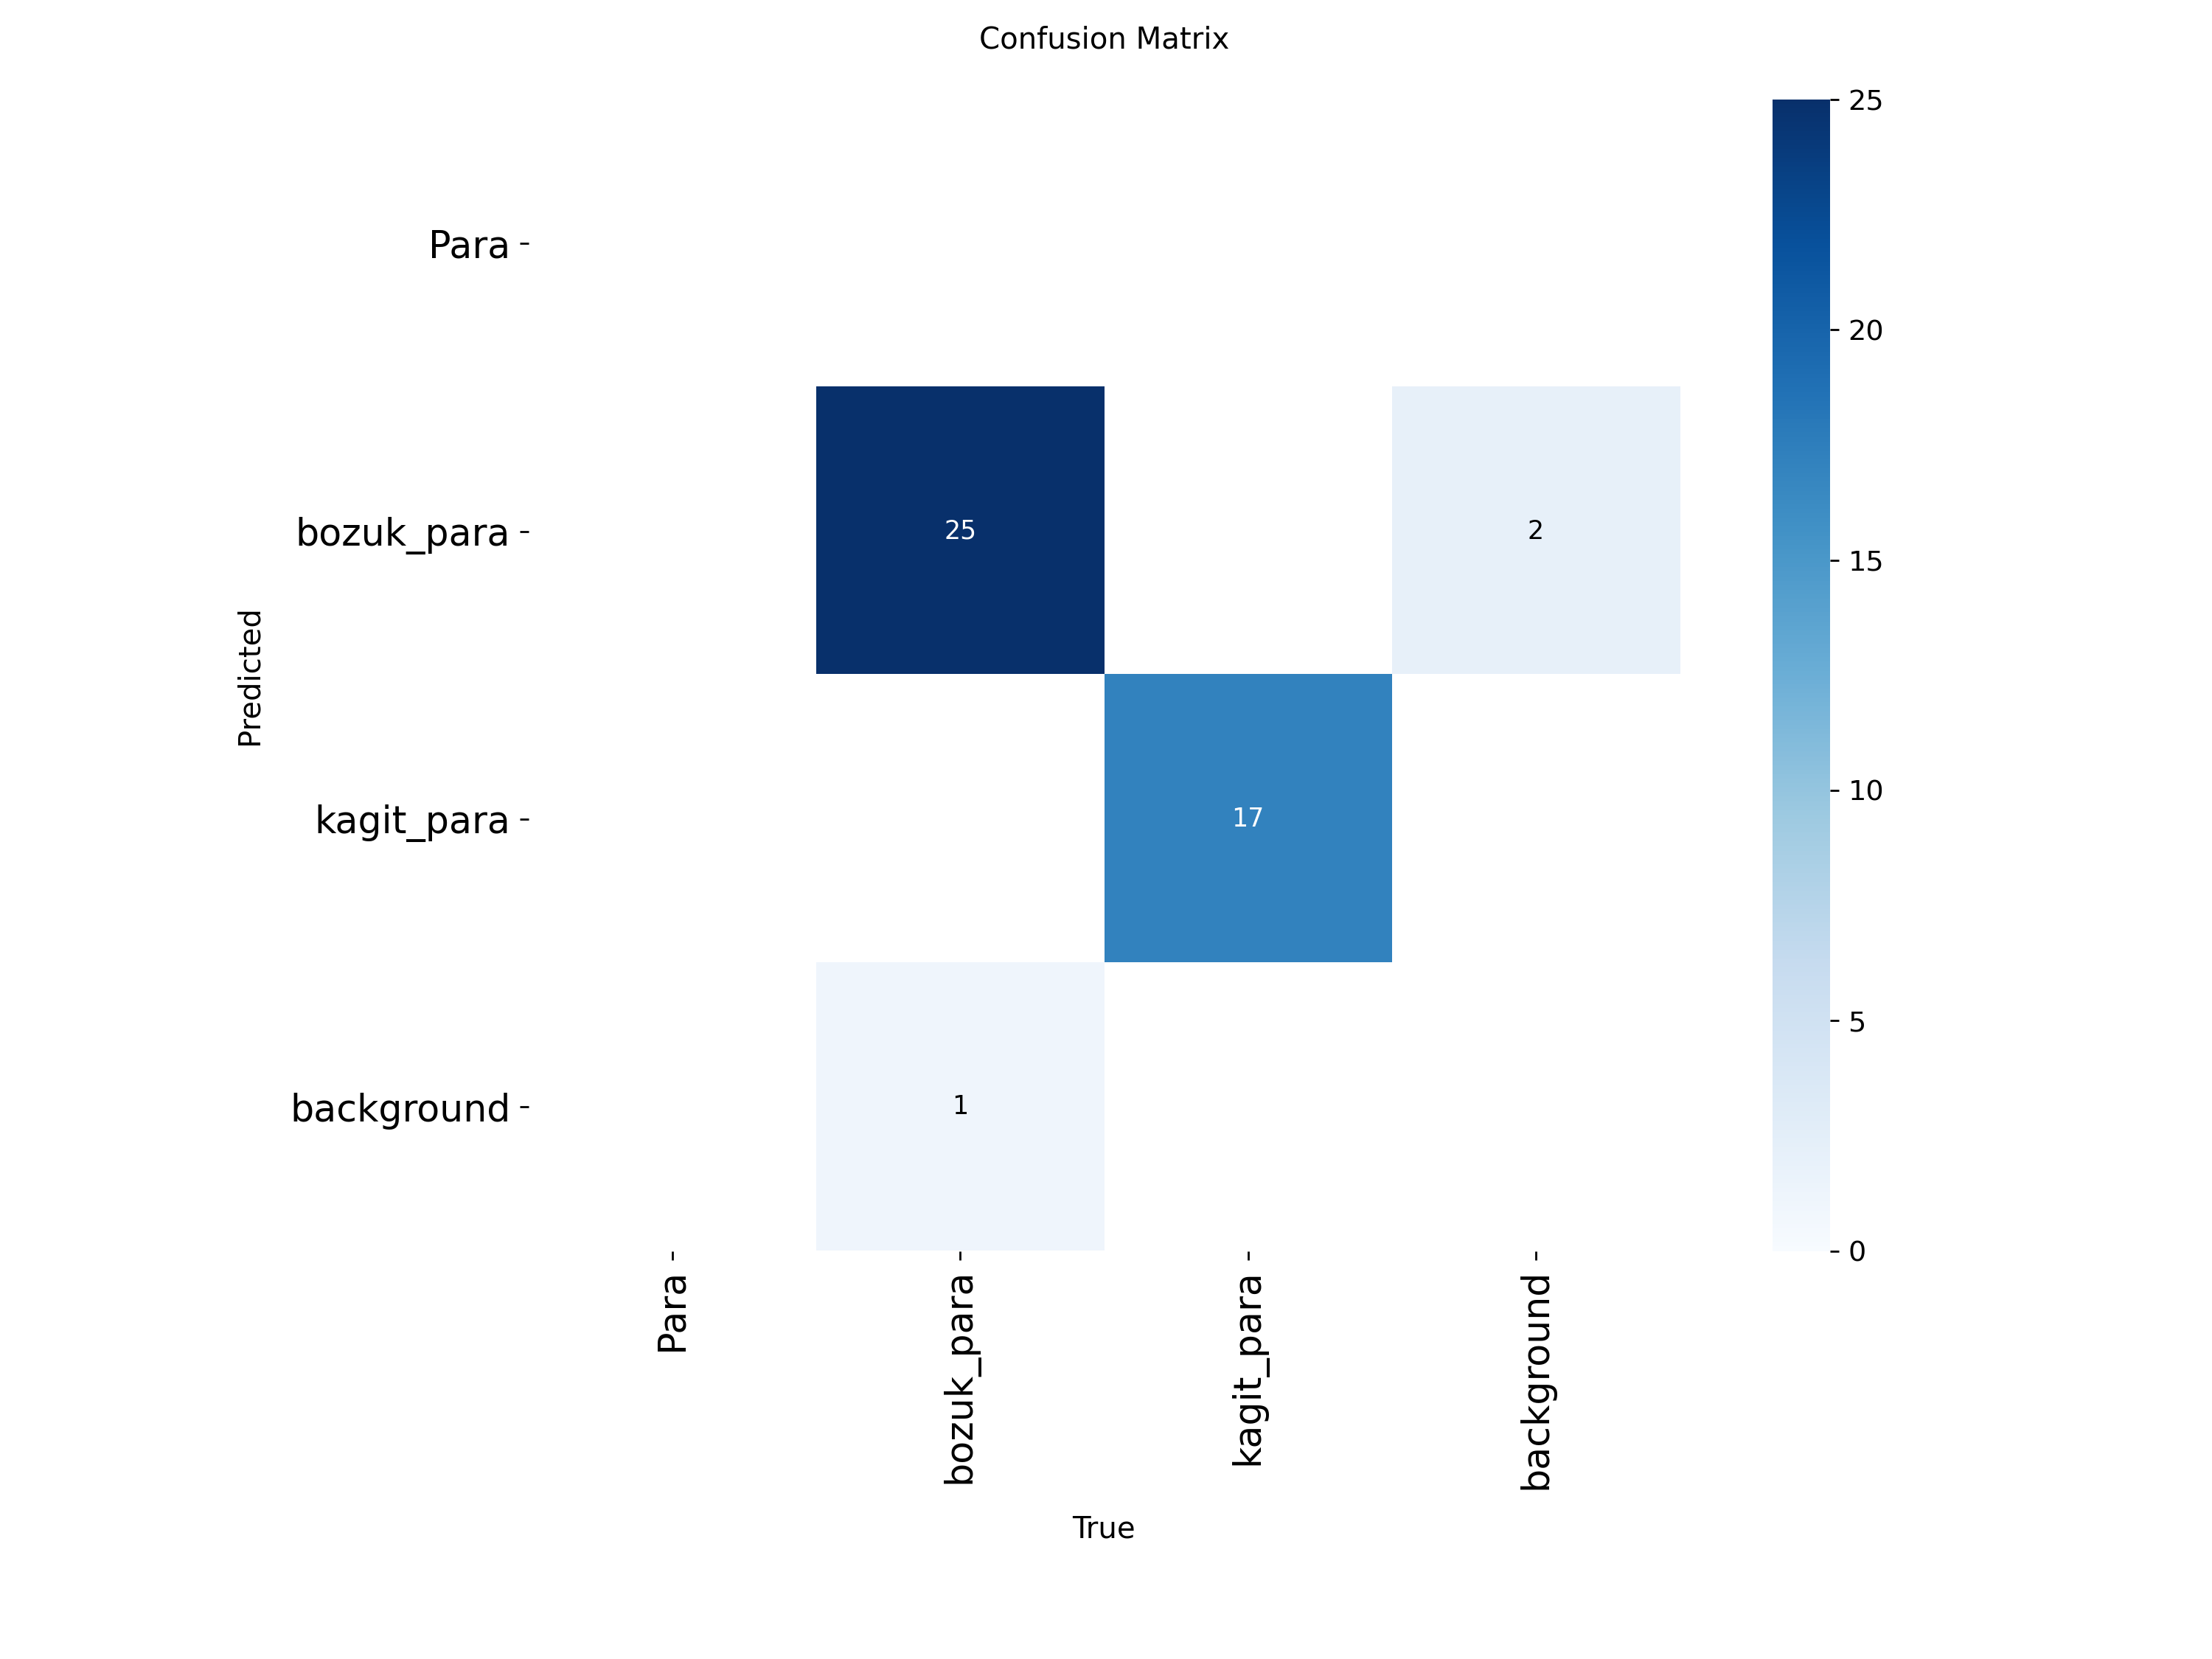

In [6]:
# ==========================================
# D) Performans Grafiklerinin Gösterilmesi
# ==========================================

from IPython.display import Image, display
import os

# En son yapılan eğitimin klasör yolunu dinamik olarak buluyoruz.
# (Bazen train, train2, train3 diye değişebildiği için en sonuncuyu alıyoruz)
egitim_klasoru = max([os.path.join("runs/detect", d) for d in os.listdir("runs/detect")], key=os.path.getmtime)
print(f"İncelenen Eğitim Klasörü: {egitim_klasoru}")

# 1. Genel Başarı Grafiği (Results)
# Bu grafik; Box Loss, Class Loss ve mAP değerlerinin her epoch'taki değişimini gösterir.
print("\n--- Eğitim Sonuçları (Loss & Accuracy) ---")
display(Image(filename=f'{egitim_klasoru}/results.png', width=800))

# 2. Karmaşıklık Matrisi (Confusion Matrix)
# Modelin tahminlerinin ne kadarının doğru, ne kadarının yanlış sınıflandırıldığını gösterir.
print("\n--- Karmaşıklık Matrisi (Confusion Matrix) ---")
display(Image(filename=f'{egitim_klasoru}/confusion_matrix.png', width=800))